# ACS2 vs ACS2ER in Multiplexer

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from lcs.metrics import population_metrics
from lcs.agents.EnvironmentAdapter import EnvironmentAdapter

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load environments
import gym
import gym_maze

from lcs.agents.acs2 import ACS2, Configuration as CFG_ACS2
from lcs.agents.acs2er import ACS2ER, Configuration as CFG_ACS2ER

# To avoid Type3 fonts in generated pdf file
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Logger
import logging
logging.basicConfig(level=logging.INFO)


# EXPERIMENT CONFIGURATION

In [4]:
MAZE = "Maze5-v0" 

EXPLORE_TRIALS = 3000
EXPLOIT_TRIALS = 500

# The size of ER replay memory buffer
ER_BUFFER_SIZE=1000
# The minimum number of samples of ER replay memory buffer to start replying samples (warm-up phase)
ER_BUFFER_MIN_SAMPLES=100
# The number of samples to be replayed druing ER phase
ER_SAMPLES_NUMBER=3


## Metrics and helpers

In [5]:
def _maze_knowledge(population, environment) -> float:
    transitions = environment.env.get_transitions()

    # Take into consideration only reliable classifiers
    reliable_classifiers = [c for c in population if c.is_reliable()]

    # Count how many transitions are anticipated correctly
    nr_correct = 0

    # For all possible destinations from each path cell
    for start, action, end in transitions:

        p0 = environment.env.maze.perception(start)
        p1 = environment.env.maze.perception(end)

        if any([True for cl in reliable_classifiers
                if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions) * 100.0

def _maze_metrics(agent, env):
    pop = agent.population
    metrics = {
        'knowledge': _maze_knowledge(pop, env)
    }

    # Add basic population metrics
    metrics.update(population_metrics(pop, env))
    
    return metrics

def parse_metrics_to_df(explore_metrics, exploit_metrics):
    def extract_details(row):
        row['trial'] = row['trial']
        row['steps'] = row['steps_in_trial']
        row['numerosity'] = row['numerosity']
        row['reliable'] = row['reliable']
        row['knowledge'] = row['knowledge']
        return row
    
    # Load both metrics into data frame
    explore_df = pd.DataFrame(explore_metrics)
    exploit_df = pd.DataFrame(exploit_metrics)
    
    # Mark them with specific phase
    explore_df['phase'] = 'explore'
    exploit_df['phase'] = 'exploit'
    
    # Extract details
    explore_df = explore_df.apply(extract_details, axis=1)
    exploit_df = exploit_df.apply(extract_details, axis=1)
    
    # Adjuts exploit trial counter
    exploit_df['trial'] = exploit_df.apply(lambda r: r['trial']+len(explore_df), axis=1)
    
    # Concatenate both dataframes
    df = pd.concat([explore_df, exploit_df])
    df.set_index('trial', inplace=True)
    
    return df

def find_best_classifier(population, situation):
    match_set = population.form_match_set(situation)
    anticipated_change_cls = [cl for cl in match_set if cl.does_anticipate_change()]
    
    if (len(anticipated_change_cls) > 0):
        return max(anticipated_change_cls, key=lambda cl: cl.fitness)
    
    return None

def build_fitness_matrix(env, population):
    original = env.env.maze.matrix
    fitness = original.copy()
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index)
            best_cl = find_best_classifier(population, perception)
            if best_cl:
                fitness[index] = best_cl.fitness
            else:
                fitness[index] = -1
        
        # Wall - fitness = 0
        if x == 1:
            fitness[index] = 0
        
        # Reward - inf fitness
        if x == 9:
            fitness[index] = fitness.max () + 500
        
    return fitness
    
def build_action_matrix(env, population):
    ACTION_LOOKUP = { 
        0: u'↑', 1: u'↗', 2: u'→', 3: u'↘',
        4: u'↓', 5: u'↙', 6: u'←', 7: u'↖'
    }
    
    original = env.env.maze.matrix
    action = original.copy().astype(str)
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index)
            best_cl = find_best_classifier(population, perception)
            if best_cl:
                action[index] = ACTION_LOOKUP[best_cl.action]
            else:
                action[index] = '?'
        
        # Wall - fitness = 0
        if x == 1:
            action[index] = '\#'
        
        # Reward - inf fitness
        if x == 9:
            action[index] = 'R'
        
    return action


# Plot constants
TITLE_TEXT_SIZE=24
AXIS_TEXT_SIZE=18
LEGEND_TEXT_SIZE=16


def plot_policy(env, agent, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.set_aspect("equal")
    
    # Handy variables
    max_x, max_y = env.env.maze.matrix.shape
    
    fitness_matrix = build_fitness_matrix(env, agent.population)
    action_matrix = build_action_matrix(env, agent.population)
    
    # Render maze as image
    plt.imshow(fitness_matrix, interpolation='nearest', cmap='Reds', aspect='auto', extent=[0, max_x, max_y, 0])
    
    
    # Add labels to each cell
    for (y,x), val in np.ndenumerate(action_matrix):
        plt.text(x+0.4, y+0.5, "${}$".format(val))
    
    ax.set_title("Policy", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel('x', fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel('y', fontsize=AXIS_TEXT_SIZE)

    ax.set_xlim(0, max_x)
    ax.set_ylim(max_y, 0)
    
    ax.set_xticks(range(0, max_x))
    ax.set_yticks(range(0, max_y))
    
    ax.grid(True)



def plot_knowledge(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
        
    explore_df['knowledge'].plot(ax=ax, c='blue')
    exploit_df['knowledge'].plot(ax=ax, c='red')
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
        
    ax.set_title("Achieved knowledge", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Knowledge [%]", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylim([0, 105])


def plot_steps(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
    
    explore_df['steps'].plot(ax=ax, c='blue', linewidth=.5)
    exploit_df['steps'].plot(ax=ax, c='red', linewidth=0.5)
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
    
    ax.set_title("Steps", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Steps", fontsize=AXIS_TEXT_SIZE)


def plot_classifiers(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
    
    df['numerosity'].plot(ax=ax, c='blue')
    df['reliable'].plot(ax=ax, c='red')    
    
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
    
    ax.set_title("Classifiers", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Classifiers", fontsize=AXIS_TEXT_SIZE)
    ax.legend(fontsize=LEGEND_TEXT_SIZE)


def plot_performance(agent, maze, metrics_df, env_name):
    plt.figure(figsize=(13, 10), dpi=100)
    plt.suptitle(f'ACS2 Performance in {env_name} environment', fontsize=32)
    
    ax1 = plt.subplot(221)
    plot_policy(maze, agent, ax1)
    
    ax2 = plt.subplot(222)
    plot_knowledge(metrics_df, ax2)
    
    ax3 = plt.subplot(223)
    plot_classifiers(metrics_df, ax3)
    
    ax4 = plt.subplot(224)
    plot_steps(metrics_df, ax4)
    
    plt.subplots_adjust(top=0.86, wspace=0.3, hspace=0.3)

<>:119: DeprecationWarning: invalid escape sequence \#


### Results arrays

ACS2 Experiments

In [6]:

### ACS2 ###
# Load desired environment
maze_acs2 = gym.make(MAZE)
# Create agent 
cfg_acs2 = CFG_ACS2(    
    classifier_length=8,
    number_of_possible_actions=8,
    metrics_trial_frequency=1,
    user_metrics_collector_fcn=_maze_metrics)
agent_acs2 = ACS2(cfg_acs2)
# Explore the environment
acs2_explore_metrics = agent_acs2.explore(maze_acs2, EXPLORE_TRIALS)
# Exploit the environment
acs2_exploit_metrics = agent_acs2.exploit(maze_acs2, EXPLOIT_TRIALS)


INFO:lcs.agents.Agent:{'trial': 300, 'steps_in_trial': 11, 'reward': 1000, 'perf_time': 0.020078699999999117, 'knowledge': 44.52054794520548, 'population': 402, 'numerosity': 402, 'reliable': 136}
INFO:lcs.agents.Agent:{'trial': 600, 'steps_in_trial': 2, 'reward': 1000, 'perf_time': 0.0032962999999881504, 'knowledge': 61.64383561643836, 'population': 385, 'numerosity': 385, 'reliable': 188}
INFO:lcs.agents.Agent:{'trial': 900, 'steps_in_trial': 10, 'reward': 1000, 'perf_time': 0.016284400000131427, 'knowledge': 73.97260273972603, 'population': 370, 'numerosity': 370, 'reliable': 219}
INFO:lcs.agents.Agent:{'trial': 1200, 'steps_in_trial': 5, 'reward': 1000, 'perf_time': 0.007005600000184131, 'knowledge': 77.3972602739726, 'population': 358, 'numerosity': 358, 'reliable': 241}
INFO:lcs.agents.Agent:{'trial': 1500, 'steps_in_trial': 9, 'reward': 1000, 'perf_time': 0.011255399999981819, 'knowledge': 80.13698630136986, 'population': 356, 'numerosity': 356, 'reliable': 251}
INFO:lcs.agents.

ACS2ER Experiments

In [7]:

### ACS2ER ###
# Load desired environment
maze_acs2er = gym.make(MAZE)
# Create agent ACS2ER
cfg_acs2er = CFG_ACS2ER(    
    classifier_length=8,
    number_of_possible_actions=8,
    metrics_trial_frequency=1,
    er_buffer_size=ER_BUFFER_SIZE,
    er_min_samples=ER_BUFFER_MIN_SAMPLES,
    er_samples_number=ER_SAMPLES_NUMBER,
    user_metrics_collector_fcn=_maze_metrics)
agent_acs2er = ACS2ER(cfg_acs2er)
# Explore the environment
acs2er_explore_metrics = agent_acs2er.explore(maze_acs2er, EXPLORE_TRIALS)
# Exploit the environment
acs2er_exploit_metrics = agent_acs2er.exploit(maze_acs2er, EXPLOIT_TRIALS)

    

INFO:lcs.agents.Agent:{'trial': 300, 'steps_in_trial': 16, 'reward': 1000, 'perf_time': 0.17991989999995894, 'knowledge': 83.56164383561644, 'population': 448, 'numerosity': 448, 'reliable': 320}
INFO:lcs.agents.Agent:{'trial': 600, 'steps_in_trial': 5, 'reward': 1000, 'perf_time': 0.05355499999996027, 'knowledge': 92.46575342465754, 'population': 432, 'numerosity': 432, 'reliable': 360}
INFO:lcs.agents.Agent:{'trial': 900, 'steps_in_trial': 4, 'reward': 1000, 'perf_time': 0.044478499999968335, 'knowledge': 93.83561643835617, 'population': 425, 'numerosity': 425, 'reliable': 375}
INFO:lcs.agents.Agent:{'trial': 1200, 'steps_in_trial': 18, 'reward': 1000, 'perf_time': 0.18868889999998828, 'knowledge': 97.26027397260275, 'population': 416, 'numerosity': 416, 'reliable': 388}
INFO:lcs.agents.Agent:{'trial': 1500, 'steps_in_trial': 7, 'reward': 1000, 'perf_time': 0.0701050000000123, 'knowledge': 98.63013698630137, 'population': 410, 'numerosity': 410, 'reliable': 393}
INFO:lcs.agents.Agent

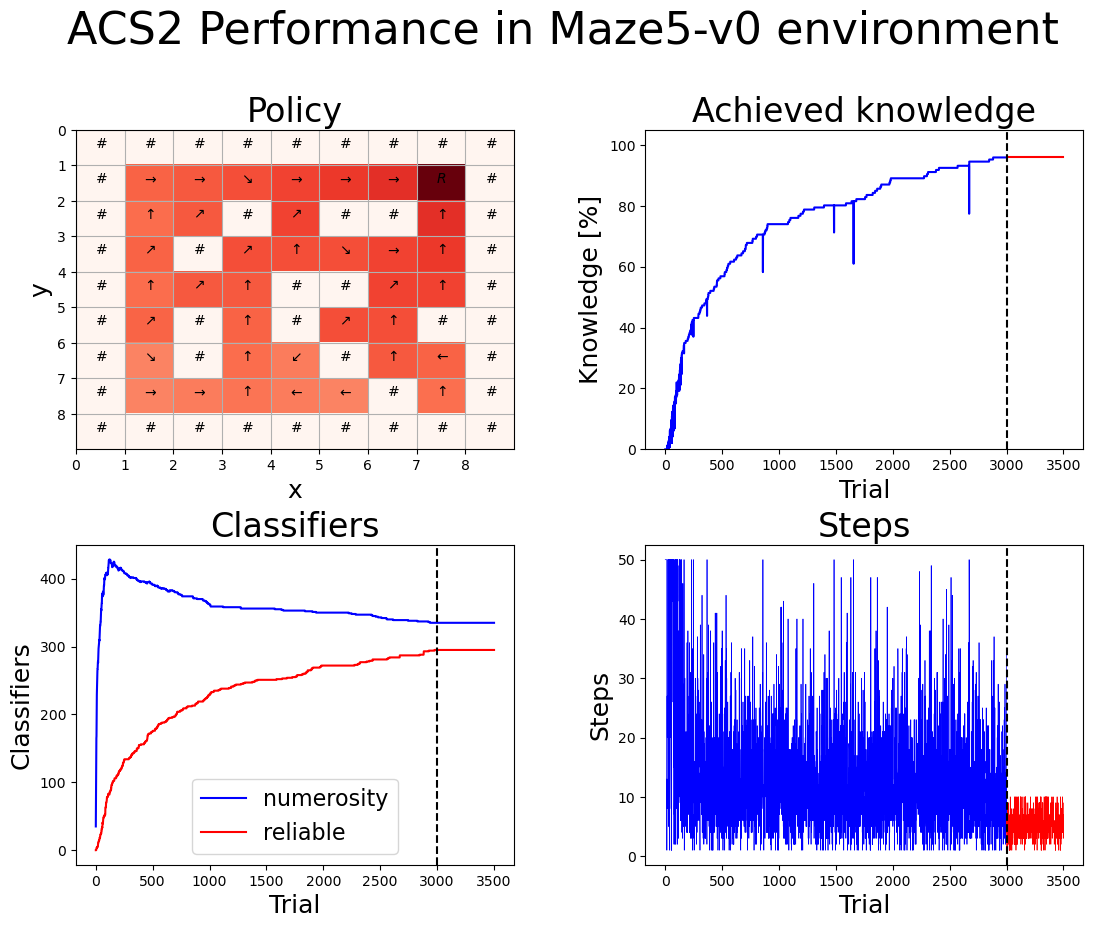

In [8]:
maze5_metrics_df_acs2 = parse_metrics_to_df(acs2_explore_metrics, acs2_exploit_metrics)
plot_performance(agent_acs2, maze_acs2, maze5_metrics_df_acs2, MAZE)

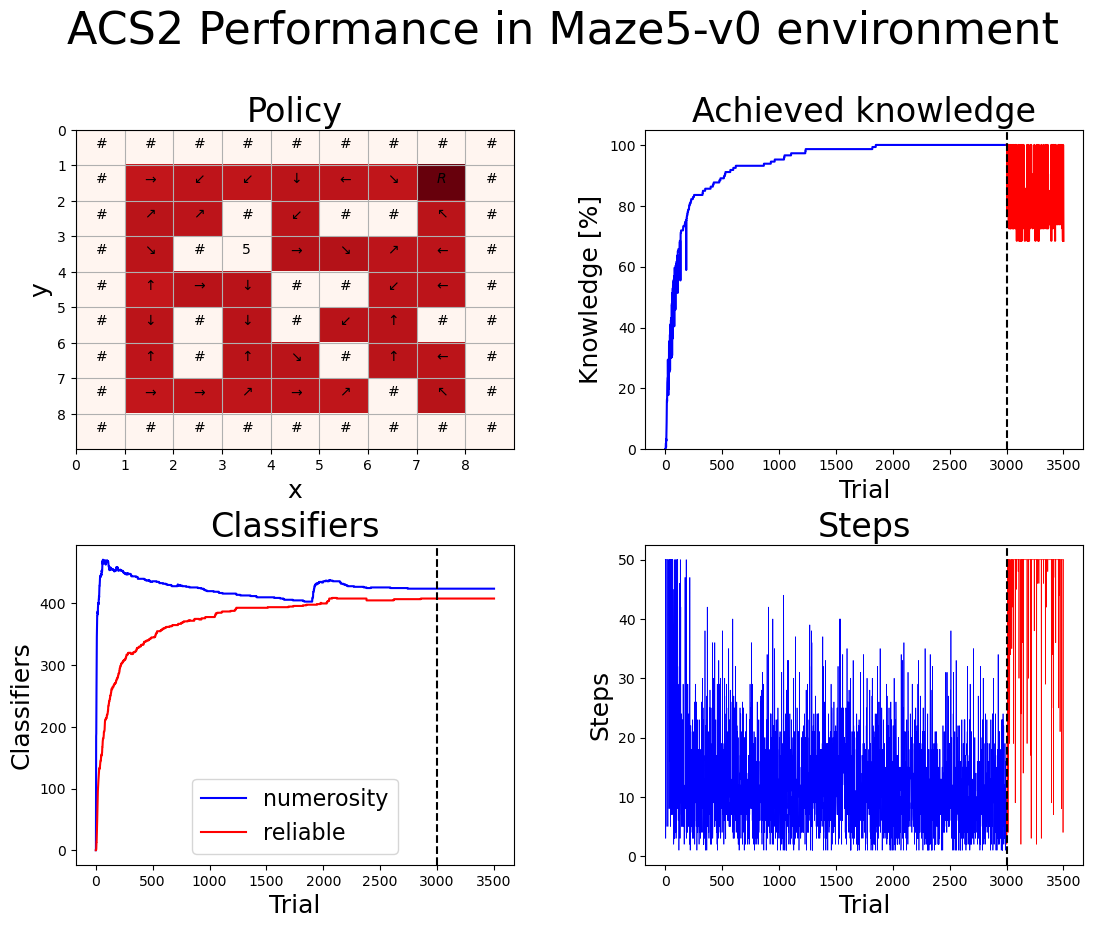

In [9]:
maze5_metrics_df_acs2er = parse_metrics_to_df(acs2er_explore_metrics, acs2er_exploit_metrics)
plot_performance(agent_acs2er, maze_acs2er, maze5_metrics_df_acs2er, MAZE)

In [9]:
# RELIABLE_KEY = "reliable"

# def extract_number_of_reliable_cl(metrics):
#     return list(map(lambda m: m[RELIABLE_KEY], metrics))

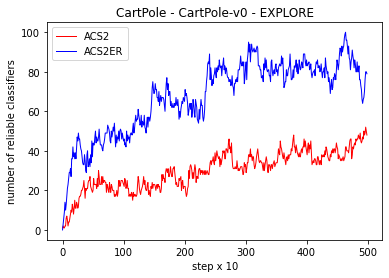

In [10]:
# acs2_reliable = extract_number_of_reliable_cl(acs2_explore_metrics)
# acs2er_reliable = extract_number_of_reliable_cl(acs2er_explore_metrics)

# x_axis = range(len(acs2_reliable))

# plt.title(f"CartPole - {CART_POLE} - EXPLORE")
# plt.plot(x_axis, acs2_reliable, c='r', label="ACS2", linewidth=1.0)
# plt.plot(x_axis, acs2er_reliable, c='b', label="ACS2ER", linewidth=1.0)
# plt.legend()
# plt.xlabel("step x 10")
# plt.ylabel("number of reliable classifiers")
# plt.show()
# # plt.savefig(f"EXPLORE_{RUN}.png")

